# **CS4120 Final Project - Vinit Patel**

## 1. Data Display + Preprocessing

In [1]:
import re
import numpy as np
import pandas as pd

### 1.1 Loading Data

In [2]:
df_train = pd.read_csv('data/train.txt', names=['text', 'emotion'], sep=';')
df_val = pd.read_csv('data/val.txt', names=['text', 'emotion'], sep=';')
df_test = pd.read_csv('data/test.txt', names=['text', 'emotion'], sep=';')

In [3]:
# combining the data files b/c they are not that big individually.
df = pd.concat([df_train, df_val, df_test])
df.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


### 1.2 Examining Data

In [4]:
# checking the shape of our data - 20,000 values
df.shape

(20000, 2)

In [5]:
# checking for null values
df.isnull().sum()

text       0
emotion    0
dtype: int64

In [6]:
# checking for duplicates since we combined the datasets
df.duplicated().sum()

1

In [7]:
# dropping the duplicate - inplace=True ensures we don't create a whole new copy
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19999 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     19999 non-null  object
 1   emotion  19999 non-null  object
dtypes: object(2)
memory usage: 468.7+ KB


### 1.3 Data Visualization
##### Making representations of the data for better understanding and emphasis

In [8]:
# imports for graphs/plots

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

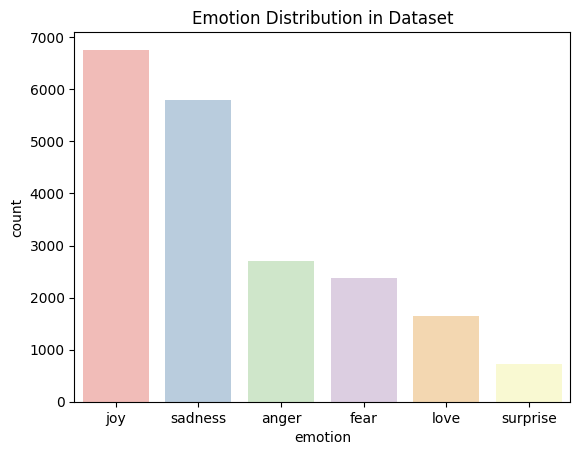

In [9]:
# displayiong how many of each emotion is present in the data
sns.countplot(x='emotion', data=df, order=df['emotion'].value_counts().index, palette='Pastel1')
plt.title('Emotion Distribution in Dataset')
plt.show()

In [10]:
df['length'] = df['text'].apply(len)
desc = df['length'].describe()
desc

count    19999.000000
mean        96.671784
std         55.778779
min          7.000000
25%         53.000000
50%         86.000000
75%        129.000000
max        300.000000
Name: length, dtype: float64

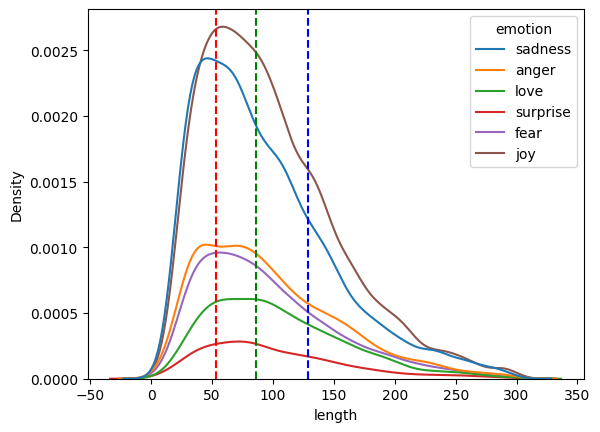

In [11]:
fig = plt.figure()
sns.kdeplot(x=df['length'], hue=df['emotion'])
plt.axvline(desc['25%'], color='r', linestyle='--', label='25%')
plt.axvline(desc['50%'], color='g', linestyle='--', label='Median')
plt.axvline(desc['75%'], color='b', linestyle='--', label='75%')
plt.show()


Above is a kde plot of the lengths of the data entries colored by emotion.
I've also drawn lines along the x-axis that show the 25th, 50th (median), and 75th
percentile of the length.

75% of the values are below 129 (according to the summary from the previous cells), while the max is 300. 


In [12]:
# creating wordclouds - found a tutorial in the matplotlib doc and thought it would be a nice visual

# necessary imports
import nltk

# prepping the lemmatizer and stopwords
lemmatizer = nltk.stem.WordNetLemmatizer()
stopwords = set(nltk.corpus.stopwords.words('english'))

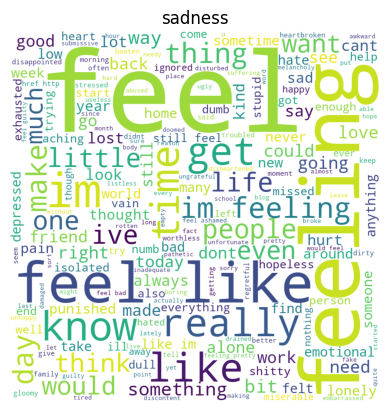

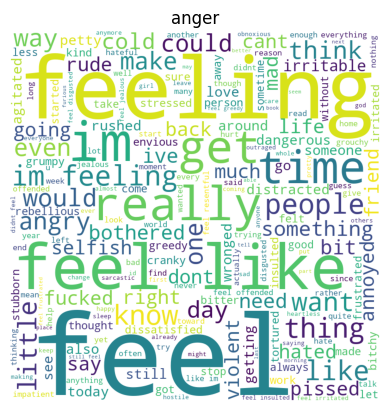

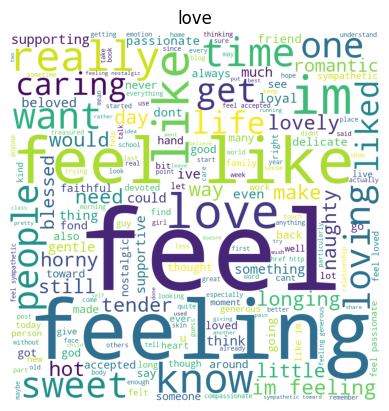

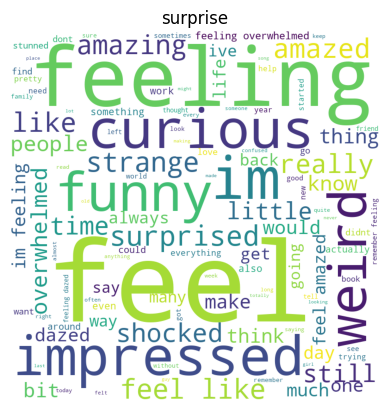

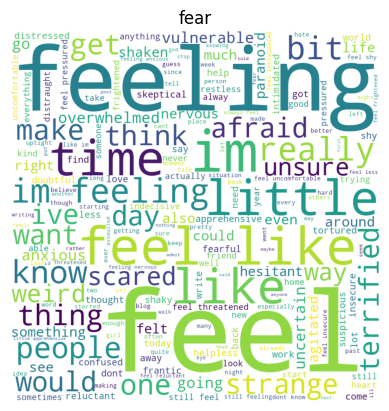

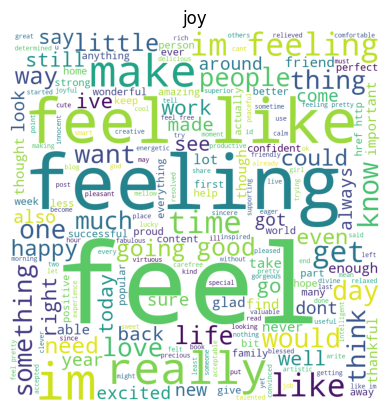

In [13]:
emotions = df['emotion'].unique()
for emotion in emotions:
    text = " ".join(df[df['emotion'] == emotion]['text'])
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(text)
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.title(emotion)
    plt.show()

### 1.4 Text Preprocessing

In [14]:
# defining a function that will process the text element of the df
def preprocess(text):
    tokens = nltk.word_tokenize(text.lower())
    filtered_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.lower() not in stopwords and token.isalnum()]
    return " ".join(filtered_tokens)

In [15]:
df['processed_text'] = df["text"].apply(preprocess)
df.head()

,text,emotion,length,processed_text
0,i didnt feel humiliated,sadness,23,didnt feel humiliated
1,i can go from feeling so hopeless to so damned...,sadness,108,go feeling hopeless damned hopeful around some...
2,im grabbing a minute to post i feel greedy wrong,anger,48,im grabbing minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,love,92,ever feeling nostalgic fireplace know still pr...
4,i am feeling grouchy,anger,20,feeling grouchy


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df["text"], df["emotion"],
                                                    test_size=0.2, random_state=42)

## 2. Models

### 2.1 Logistic Regression

In [17]:
# imports for LR
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [18]:
# converting data to tf-idf vectors
tfidf = TfidfVectorizer(max_features=5000)
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)

In [19]:
# training the lr model
lr_model = LogisticRegression(max_iter=10000)
lr_model.fit(X_train_tf, y_train)

LogisticRegression(max_iter=10000)

In [20]:
lr_pred = lr_model.predict(X_test_tf)
lr_accuracy = accuracy_score(y_test, lr_pred)
print("LR Accuracy", lr_accuracy)
print("Classification Report:")
print(classification_report(y_test, lr_pred))

LR Accuracy 0.8715
Classification Report:
              precision    recall  f1-score   support

       anger       0.91      0.82      0.86       537
        fear       0.84      0.75      0.79       441
         joy       0.84      0.96      0.90      1334
        love       0.89      0.66      0.76       330
     sadness       0.90      0.95      0.92      1203
    surprise       0.86      0.47      0.61       155

    accuracy                           0.87      4000
   macro avg       0.87      0.77      0.81      4000
weighted avg       0.87      0.87      0.87      4000



LR Confusion Matrix:


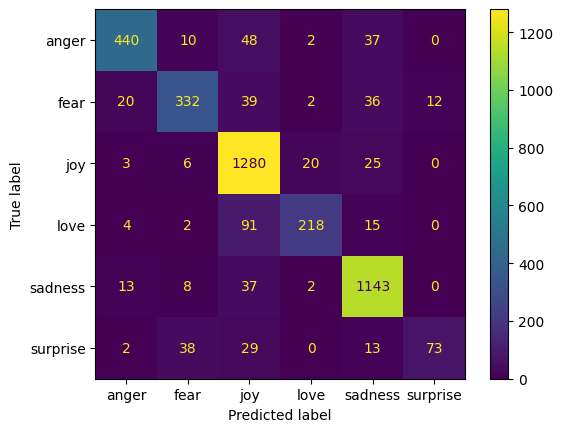

In [21]:
lr_cm = confusion_matrix(y_test, lr_pred)
print("LR Confusion Matrix:")
disp_lr = ConfusionMatrixDisplay(confusion_matrix=lr_cm, display_labels=lr_model.classes_)
disp_lr.plot()
plt.show()

### 2.2 LSTM

In [22]:
# imports for LSTM

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder

In [23]:
# tokenizing
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['processed_text'])
X = tokenizer.texts_to_sequences(df['processed_text']) 
max_length = max([len(x) for x in X])
X = pad_sequences(X, maxlen=max_length)

vocabsize = len(tokenizer.index_word) + 1
lstm_output_dim = 128

In [24]:
# encoding labels
label_encoder_lstm = LabelEncoder()
y = label_encoder_lstm.fit_transform(df['emotion'])

In [25]:
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X, y, test_size=0.2, random_state=42)

# X_train_lstm.size

In [26]:
# building LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=vocabsize, output_dim=lstm_output_dim))
lstm_model.add(Dropout(0.25))
lstm_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(len(label_encoder_lstm.classes_), activation='softmax'))

lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
# training the LSTM
history = lstm_model.fit(X_train_lstm, y_train_lstm, epochs = 5, batch_size=64, validation_split=0.1, 
                         callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.3821 - loss: 1.5327 - val_accuracy: 0.7519 - val_loss: 0.7178
Epoch 2/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.8456 - loss: 0.4757 - val_accuracy: 0.9019 - val_loss: 0.2802
Epoch 3/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.9511 - loss: 0.1525 - val_accuracy: 0.9056 - val_loss: 0.2625
Epoch 4/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.9724 - loss: 0.0811 - val_accuracy: 0.9119 - val_loss: 0.2516
Epoch 5/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.9792 - loss: 0.0596 - val_accuracy: 0.9031 - val_loss: 0.2715


In [28]:
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_lstm, y_test_lstm)
print("LSTM Accuracy:", lstm_accuracy)
print("LSTM Loss:", lstm_loss)

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9201 - loss: 0.2400
LSTM Accuracy: 0.9157500267028809
LSTM Loss: 0.2465364634990692


In [29]:
# an lstm returns probabilities instead of labels, so we need some adjustments for the confusion matrix
lstm_pred = lstm_model.predict(X_test_lstm)
# getting the labels with numpy
lstm_pred_labels = np.argmax(lstm_pred, axis=1)
# a Sequential object doesn't have 'classes' so we'll identify each label here, and I'll label them 
# below the confusion matrix according to the emotion
unique_labels = np.unique(y_test_lstm)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


LSTM Confusion Matrix:


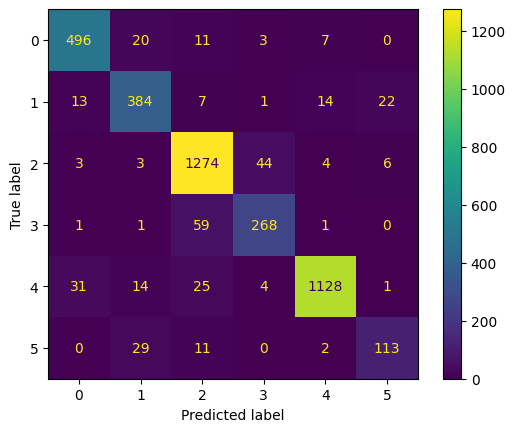

In [30]:
lstm_cm = confusion_matrix(y_test_lstm, lstm_pred_labels)
print("LSTM Confusion Matrix:")
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=lstm_cm, display_labels=unique_labels)
disp_lstm.plot()
plt.show()

#### **0 = anger | 1 = fear  | 2 = joy | 3 = love | 4 = sadness | 5 = surprise**

### 2.3 Transformer-Based Model - BERT

In [72]:
# necessary imports
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, DistilBertConfig, AdamW
import torch
from tqdm.notebook import tqdm_notebook

In [ ]:
# defining a distilbert tokenizer and tokenizing the text from our df
btokenizer=DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

tokenized_texts = [btokenizer.tokenize(text) for text in df['text']]

In [34]:
input_ids = [btokenizer.convert_tokens_to_ids(tokens) for tokens in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=max_length, dtype="long", truncating="post", padding="post")
input_ids = torch.tensor(input_ids)

In [73]:
# got a warning that suggested using attention masks - simple implementation based on documentation
attention_masks = []
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)
attention_masks = torch.tensor(attention_masks)

In [74]:
# once again using label encodings b/c we are working with 6 emotions
blabel_encoder = LabelEncoder()
labels = blabel_encoder.fit_transform(df['emotion'])
labels = torch.tensor(labels)
labels = labels.long()

In [42]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [75]:
# defining our dataset and dataloader and instantiating our model
batch_size = 32
dataset = TensorDataset(input_ids, attention_masks, labels)
dataloader = DataLoader(dataset, sampler=RandomSampler(dataset), batch_size=batch_size)
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(df['emotion'].unique()))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [76]:
# no gpu :c
device = torch.device("cpu")
model.to(device)

# params
epochs = 3
learning_rate=2e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)

C:\Users\vinit\anaconda3\Lib\site-packages\transformers\optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [77]:
# setting model to train mode
model.train()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [53]:
# training loop
for epoch in range(epochs):
    # initializing the loss to 0
    total_loss = 0
    # using tqdm for visualizing the progress (slow laptop :c)
    progress_bar = tqdm_notebook(dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
    for batch in progress_bar:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        model.zero_grad()
        # forward pass
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels.long())
        loss = outputs.loss  
        # backward pass
        loss.backward()
        # updates the parameters
        optimizer.step()
        total_loss += loss.item()
        
        # updating the tqdm progress bar
        progress_bar.set_postfix({'loss': loss.item()})
    
    # calculating the average loss
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss}")

Epoch 1/3:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1/3, Average Loss: 0.5906902813017368


Epoch 2/3:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 2/3, Average Loss: 0.19018720824718474


Epoch 3/3:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 3/3, Average Loss: 0.1392148525521159


In [54]:
model_path = "distilbert_model.pth"
torch.save(model.state_dict(), model_path)

In [78]:
# need to do this configuration because we are working with 6 emotions
# instead of a case where it is just 2 (i.e. positive vs negative sentiment)
config = DistilBertConfig.from_pretrained('distilbert-base-uncased')
config.num_labels = len(df['emotion'].unique())

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', config=config)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [64]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [65]:
model.eval()
predictions = []
true_labels = []

In [67]:
# using tqdm once again to get an estimate on the time
for batch in tqdm_notebook(dataloader, desc="Evaluating", leave=False):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    
    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask)
    
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    predictions.extend(preds)
    true_labels.extend(b_labels.cpu().numpy())

Evaluating:   0%|          | 0/625 [00:00<?, ?it/s]

In [79]:
# calculating the accuracy
accuracy = accuracy_score(true_labels, predictions)
print("DistilBERT Accuracy:", accuracy)

# printing a classification report
print("Classification Report:")
print(classification_report(true_labels, predictions))

DistilBERT Accuracy: 0.9651482574128707
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2709
           1       0.93      0.97      0.95      2373
           2       0.97      0.98      0.98      6760
           3       0.94      0.90      0.92      1641
           4       0.99      0.98      0.98      5797
           5       0.93      0.79      0.86       719

    accuracy                           0.97     19999
   macro avg       0.95      0.93      0.94     19999
weighted avg       0.97      0.97      0.96     19999



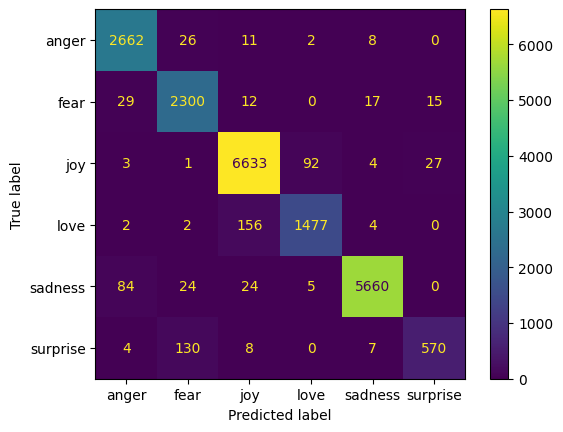

In [80]:
bert_cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=bert_cm, display_labels=blabel_encoder.classes_)
disp.plot()
plt.show()